In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',origin=_URL,extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 8s 0us/step
Found 2000 files belonging to 2 classes.
Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-11-05 12:40:47.958831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-05 12:40:47.959030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


2022-11-05 12:43:48.088533: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


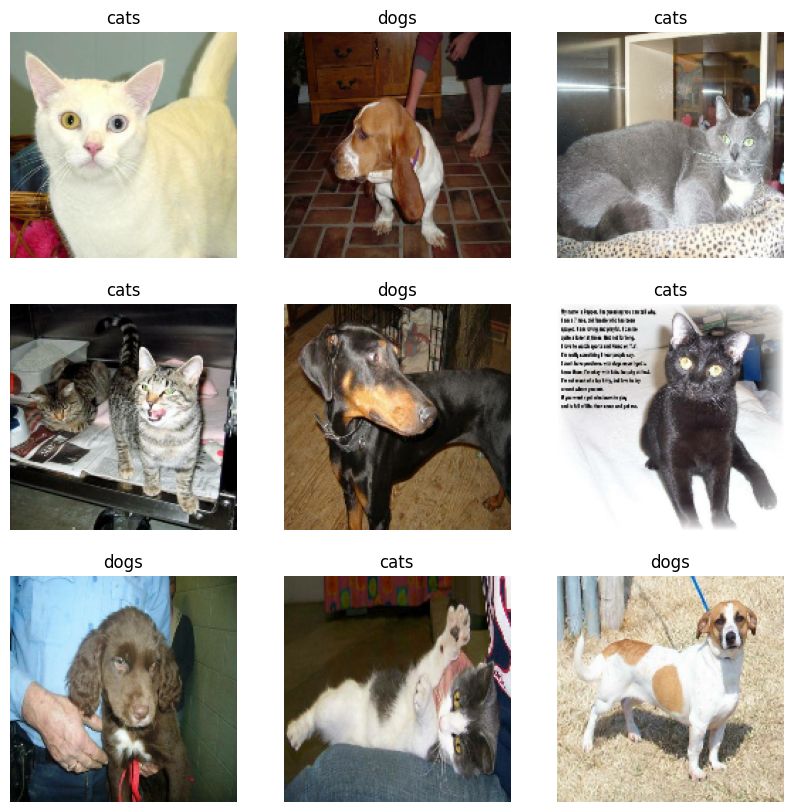

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5,offset=-1)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

58889256/58889256 [==============================] - 8s 0us/step


In [8]:
image_batch,label_batch = next(iter(train_dataset))
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [9]:
#not allowing weights to change
base_model.trainable=False

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [13]:
prediction_layer=tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
inputs = tf.keras.Input(shape=(160,160,3))
x = preprocess_input(inputs)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

In [19]:
initial_epochs = 10
loss0,accuracy0 = model.evaluate(validation_dataset)

2022-11-05 12:56:55.010236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 88ms/step - loss: 0.7853 - accuracy: 0.4410


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


2022-11-05 12:57:59.801161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 9s 127ms/step - loss: 0.7637 - accuracy: 0.4780 - val_loss: 0.7239 - val_accuracy: 0.4920
Epoch 2/10
63/63 [==============================] - 9s 140ms/step - loss: 0.7264 - accuracy: 0.5010 - val_loss: 0.6934 - val_accuracy: 0.5450
Epoch 3/10
63/63 [==============================] - 9s 145ms/step - loss: 0.6981 - accuracy: 0.5230 - val_loss: 0.6718 - val_accuracy: 0.5630
Epoch 4/10
63/63 [==============================] - 9s 150ms/step - loss: 0.6750 - accuracy: 0.5610 - val_loss: 0.6529 - val_accuracy: 0.5760
Epoch 5/10
63/63 [==============================] - 9s 150ms/step - loss: 0.6605 - accuracy: 0.5835 - val_loss: 0.6354 - val_accuracy: 0.6030
Epoch 6/10
63/63 [==============================] - 9s 149ms/step - loss: 0.6484 - accuracy: 0.5850 - val_loss: 0.6187 - val_accuracy: 0.6260
Epoch 7/10
63/63 [==============================] - 9s 150ms/step - loss: 0.6273 - accuracy: 0.6165 - val_loss: 0.6033 - val_accuracy: 0.6420
Epoch 8/10
63/63 